In [1]:
import os
import sys
import pickle
import random
from itertools import product
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.preprocessing import minmax_scale, scale, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import ccf

sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline


def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [2]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-27.csv")
# print(df_covid.columns)

In [3]:
df_covid = df_covid.drop(df_covid.index[df_covid["state"] == "TOTAL"])

In [4]:
covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()

In [5]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
hashtags_["date"] = hashtags_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
hashtags_ = hashtags_[hashtags_["date"] > pd.Timestamp(2020, 1, 1)]
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [6]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

datas = df_merged["date"].to_numpy()

In [7]:
print(df_merged.corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.909656     0.717303
newDeaths    0.909656   1.000000     0.730480
numComments  0.717303   0.730480     1.000000


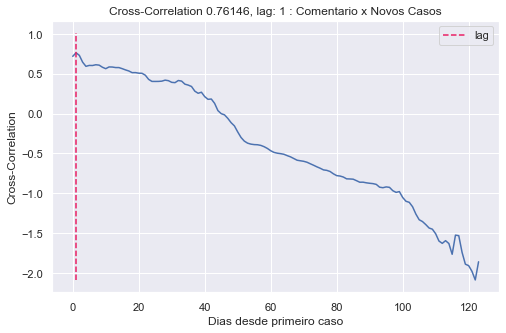

In [8]:
ccf_ = ccf(df_merged["newCases"], df_merged["numComments"])
displace_in_time = np.argmax(ccf_)

plt.figure(figsize=(8, 5))
plt.title(f"Cross-Correlation {round(np.max(ccf_), 5)}, lag: {displace_in_time} : Comentario x Novos Casos")
plt.plot(ccf_)
plt.plot([displace_in_time, displace_in_time], [np.min(ccf_), np.max(ccf_) + 0.25], "--", c="#e91e63", label="lag")
plt.xlabel("Dias desde primeiro caso")
plt.ylabel("Cross-Correlation")
plt.legend()
plt.show()

In [9]:
print(df_merged.diff(7).corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.426973     0.193108
newDeaths    0.426973   1.000000     0.179902
numComments  0.193108   0.179902     1.000000


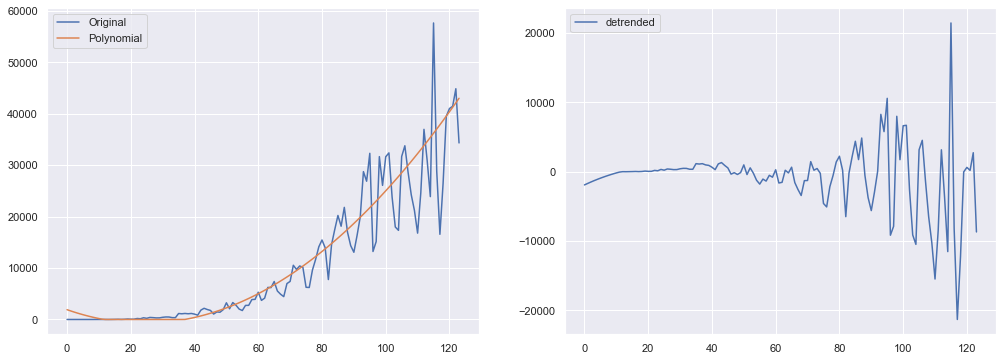

In [10]:
X = [i for i in range(0, len(df_merged["newCases"]))]
X = np.reshape(X, (len(X), 1))
X = PolynomialFeatures(2).fit_transform(X)
y = df_merged["newCases"]

split = int(len(y) * .8)

X_train = [i for i in range(0, len(df_merged["newCases"]))][:split]
X_train = np.reshape(X_train, (len(X_train), 1))
X_train = PolynomialFeatures(2).fit_transform(X_train)
y_train = df_merged["newCases"][:split]

model = LinearRegression()
model.fit(X_train, y_train)
# calculate trend
trend = model.predict(X).astype(np.int)
trend[trend < 0] = 0
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(y))]

plt.figure(figsize=(17, 6))
# plot trend
plt.subplot(1, 2, 1)
plt.plot(y, label="Original")
plt.plot(trend, label="Polynomial")
plt.legend()
# plot detrended
plt.subplot(1, 2, 2)
plt.plot(detrended, label="detrended")
plt.legend()
plt.show()

In [11]:
print(pd.DataFrame(np.c_[detrended, df_merged[['newDeaths', 'numComments']]], columns=['newCases', 'newDeaths', 'numComments']).diff().corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.512822     0.026130
newDeaths    0.512822   1.000000    -0.069368
numComments  0.026130  -0.069368     1.000000


In [12]:
parameters = {
    "hidden_layer_sizes": [(128, 5), (256, 5), (512, 5)],
    "activation": ['relu', 'tanh'],
    "max_iter": [5000]
}

In [13]:
metrics = []
for p in range(1, 5):
    for N in range(p, 15):
        X, y, z = [], [], []
        for m in range(0, len(df_merged)-(N+1)):
            arr = []
            for n in range(p):
                arr.append(df_merged["numComments"][m+n])
            X.append(arr)
            y.append(detrended[m+N])
            z.append(trend[m+N])
        X = np.asarray(X).reshape(-1, p)
        y = np.asarray(y).reshape(-1, 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

        std = StandardScaler().fit(X_train)
        X_train = std.transform(X_train)
        X_test = std.transform(X_test)

        std_y = StandardScaler().fit(y_train)
        y_train = std_y.transform(y_train).ravel()
        y_test = std_y.transform(y_test).ravel()

        md = GridSearchCV(MLPRegressor(), parameters, n_jobs=-1)
        md.fit(X_train, y_train)

        y_pred = md.predict(X_test).ravel().astype(np.int)
        mse = np.sqrt(mean_squared_error(y_test, y_pred))

        metrics.append((p, N, mse, md.best_params_))

In [14]:
df = pd.DataFrame(metrics, columns=["p", "N", "RMSE", "PARAMS"])
df["RMSE"] = df["RMSE"]
df = df.sort_values(by=["RMSE"], ascending=True)

print(df.head(25))
select_p = df.iloc[0]['p']
select_lags = df.iloc[0]['N']
selected_params = df.iloc[0]['PARAMS']


print()
print(select_lags)
print(selected_params)

    p   N      RMSE                                             PARAMS
49  4  14  4.374135  {'activation': 'tanh', 'hidden_layer_sizes': (...
26  2  14  4.374135  {'activation': 'tanh', 'hidden_layer_sizes': (...
13  1  14  4.374135  {'activation': 'tanh', 'hidden_layer_sizes': (...
37  3  13  4.401101  {'activation': 'tanh', 'hidden_layer_sizes': (...
25  2  13  4.401101  {'activation': 'tanh', 'hidden_layer_sizes': (...
12  1  13  4.401101  {'activation': 'relu', 'hidden_layer_sizes': (...
11  1  12  4.427909  {'activation': 'tanh', 'hidden_layer_sizes': (...
24  2  12  4.427909  {'activation': 'tanh', 'hidden_layer_sizes': (...
43  4   8  4.439066  {'activation': 'relu', 'hidden_layer_sizes': (...
10  1  11  4.454477  {'activation': 'relu', 'hidden_layer_sizes': (...
38  3  14  4.463264  {'activation': 'tanh', 'hidden_layer_sizes': (...
9   1  10  4.624448  {'activation': 'relu', 'hidden_layer_sizes': (...
34  3  10  4.624448  {'activation': 'tanh', 'hidden_layer_sizes': (...
22  2 

RMSE : 4.945424683888632


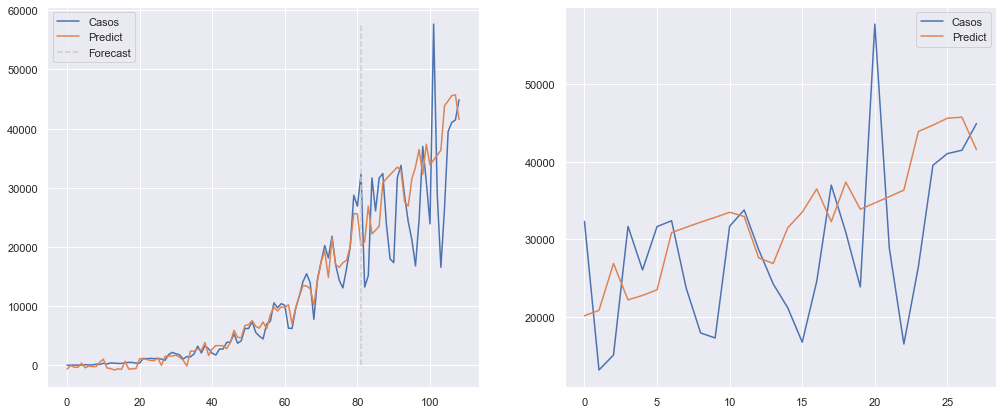

In [15]:
N, p = select_lags, select_p
X, y, z = [], [], []
for m in range(0, len(df_merged)-(N+1)):
    arr = []
    for n in range(p):
        arr.append(df_merged["numComments"][m+n])
    X.append(arr)
    y.append(detrended[m+N])
    z.append(trend[m+N])
X = np.asarray(X).reshape(-1, p)
y = np.asarray(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
split = len(X_train)

std = StandardScaler().fit(X_train)
X_train, X_test = std.transform(X_train), std.transform(X_test)

std_y = StandardScaler().fit(y_train)
y_train = std_y.transform(y_train).ravel()
y_test = std_y.transform(y_test).ravel()

md = MLPRegressor(**selected_params)
md.fit(X_train, y_train)
y_pred = md.predict(X_test).ravel()
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred))}")

plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plt.plot(
    (np.concatenate((std_y.inverse_transform(y_train) + z[:split], std_y.inverse_transform(y_test) + z[split:]))).astype(np.int),
    label="Casos"
)
plt.plot(
    (std_y.inverse_transform(md.predict(std.transform(X)).astype(np.float).ravel()) + z).astype(np.int),
    label="Predict"
)
plt.plot([split, split], [0, np.max(df_merged["newCases"])], "--", c="#ccc", label="Forecast")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot((std_y.inverse_transform(y_test) + z[split:]).astype(np.int), label="Casos")
plt.plot((std_y.inverse_transform(y_pred) + z[split:]).astype(np.int), label="Predict")
plt.legend()
plt.show()

---

In [17]:
metrics = []
for p in range(1, 5):
    for N in range(p, 25):
        X, y, z = [], [], []
        for m in range(0, len(df_merged)-(N+1)):
            arr = []
            for n in range(p):
                arr.append(df_merged["numComments"][m+n])
            X.append(arr)
            y.append(df_merged["newCases"][m+N])
        X = np.asarray(X).reshape(-1, p)
        y = np.asarray(y).ravel()

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

        std = StandardScaler().fit(X)
        X_train, X_test = std.transform(X_train), std.transform(X_test)

        md = GridSearchCV(MLPRegressor(), parameters, n_jobs=-1)
        md.fit(X_train, np.log1p(y_train))

        y_pred = md.predict(X_test).ravel()
        y_pred[y_pred < 0] = 0
        rmsle_ = rmsle(y_test, y_pred)

        metrics.append((p, N, rmsle_, md.best_params_))

/home/rdenadai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rdenadai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rdenadai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rdenadai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged ye

In [18]:
df = pd.DataFrame(metrics, columns=["p", "N", "RMSLE", "PARAMS"])
df["RMSLE"] = df["RMSLE"]
df = df.sort_values(by=["RMSLE"], ascending=True)

print(df.head(15))
select_p = df.iloc[0]['p']
select_lags = df.iloc[0]['N']
selected_params = df.iloc[0]['PARAMS']

print()
print(selected_params)

    p   N     RMSLE                                             PARAMS
76  4  11  7.851083  {'activation': 'relu', 'hidden_layer_sizes': (...
17  1  18  7.860774  {'activation': 'relu', 'hidden_layer_sizes': (...
53  3   9  7.867931  {'activation': 'relu', 'hidden_layer_sizes': (...
29  2   7  7.872705  {'activation': 'relu', 'hidden_layer_sizes': (...
16  1  17  7.873071  {'activation': 'relu', 'hidden_layer_sizes': (...
14  1  15  7.874030  {'activation': 'relu', 'hidden_layer_sizes': (...
20  1  21  7.879777  {'activation': 'relu', 'hidden_layer_sizes': (...
42  2  20  7.884445  {'activation': 'relu', 'hidden_layer_sizes': (...
18  1  19  7.884832  {'activation': 'relu', 'hidden_layer_sizes': (...
15  1  16  7.885080  {'activation': 'relu', 'hidden_layer_sizes': (...
19  1  20  7.886455  {'activation': 'relu', 'hidden_layer_sizes': (...
24  2   2  7.889650  {'activation': 'relu', 'hidden_layer_sizes': (...
37  2  15  7.890473  {'activation': 'relu', 'hidden_layer_sizes': (...
12  1 

RMSLE : 1.8127715470064922


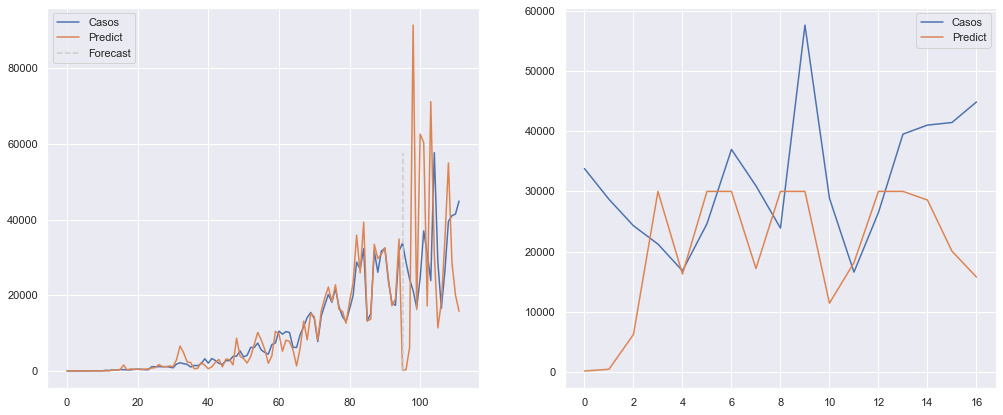

In [23]:
N, p = select_lags, select_p
X, y, z = [], [], []
for m in range(0, len(df_merged)-(N+1)):
    arr = []
    for n in range(p):
        arr.append(df_merged["numComments"][m+n])
    X.append(arr)
    y.append(df_merged["newCases"][m+N])

X = np.asarray(X).reshape(-1, p)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
split = len(X_train)

std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

md = MLPRegressor(**selected_params)
# md = LinearRegression()
md.fit(X_train, np.log1p(y_train))
y_pred = np.expm1(md.predict(X_test)).astype(np.int)
y_pred[y_pred > 30000] = 30000
print(f"RMSLE : {rmsle(y_test, y_pred)}")

plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plt.plot(
    (np.concatenate((y_train, y_test))),
    label="Casos"
)
plt.plot(
    (np.expm1(md.predict(std.transform(X)).ravel())).astype(np.int),
    label="Predict"
)
plt.plot([split, split], [0, np.max(df_merged["newCases"])], "--", c="#ccc", label="Forecast")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_test, label="Casos")
plt.plot(y_pred, label="Predict")
plt.legend()
plt.show()